# Introduction

# Import libraries

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Import data

In [5]:
# Load the dataset
file_path = 'data/ChCh-Miner_durgbank-chem-chem.tsv.gz'
df = pd.read_csv(file_path, sep='\t', compression='gzip', header=None, names=['Drug1', 'Drug2'])
df

,Drug1,Drug2
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [6]:
# Create a graph from the dataframe
G = nx.from_pandas_edgelist(df, 'Drug1', 'Drug2')

# Basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Is the graph connected?", nx.is_connected(G))

Number of nodes: 1514
Number of edges: 48514
Is the graph connected? False


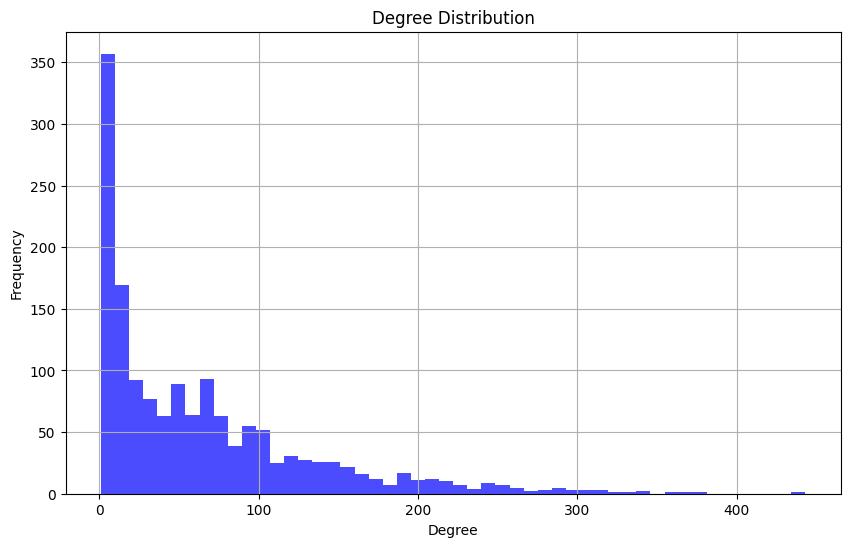

Average degree: 64.08718626155878
Maximum degree: 443
Minimum degree: 1


In [7]:
# Degree distribution
degrees = [G.degree(n) for n in G.nodes()]
degree_counts = nx.degree_histogram(G)

# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='blue', alpha=0.7)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print some statistics
print("Average degree:", sum(degrees) / len(degrees))
print("Maximum degree:", max(degrees))
print("Minimum degree:", min(degrees))


Average clustering coefficient: 0.3039679581007187


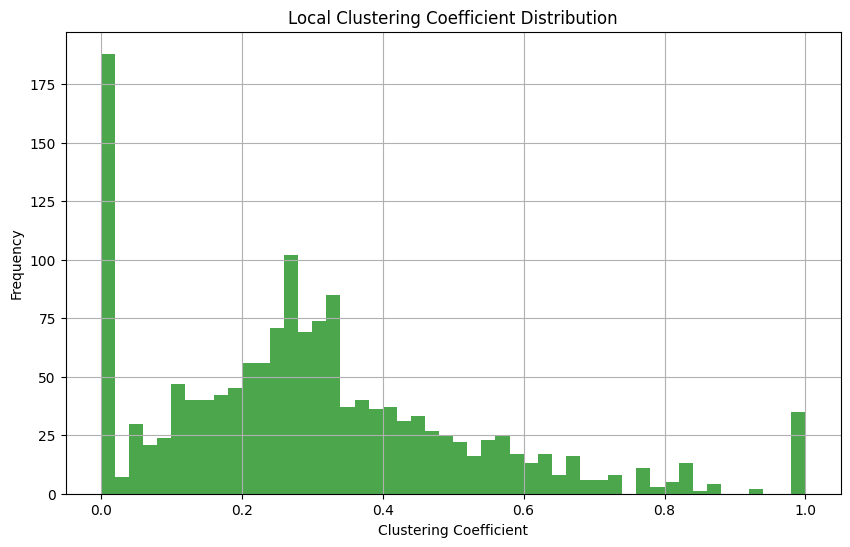

In [8]:
# Average clustering coefficient
avg_clustering = nx.average_clustering(G)
print("Average clustering coefficient:", avg_clustering)

# Local clustering coefficient for each node
local_clustering = nx.clustering(G)

# Plot local clustering coefficient distribution
plt.figure(figsize=(10, 6))
plt.hist(local_clustering.values(), bins=50, color='green', alpha=0.7)
plt.title('Local Clustering Coefficient Distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

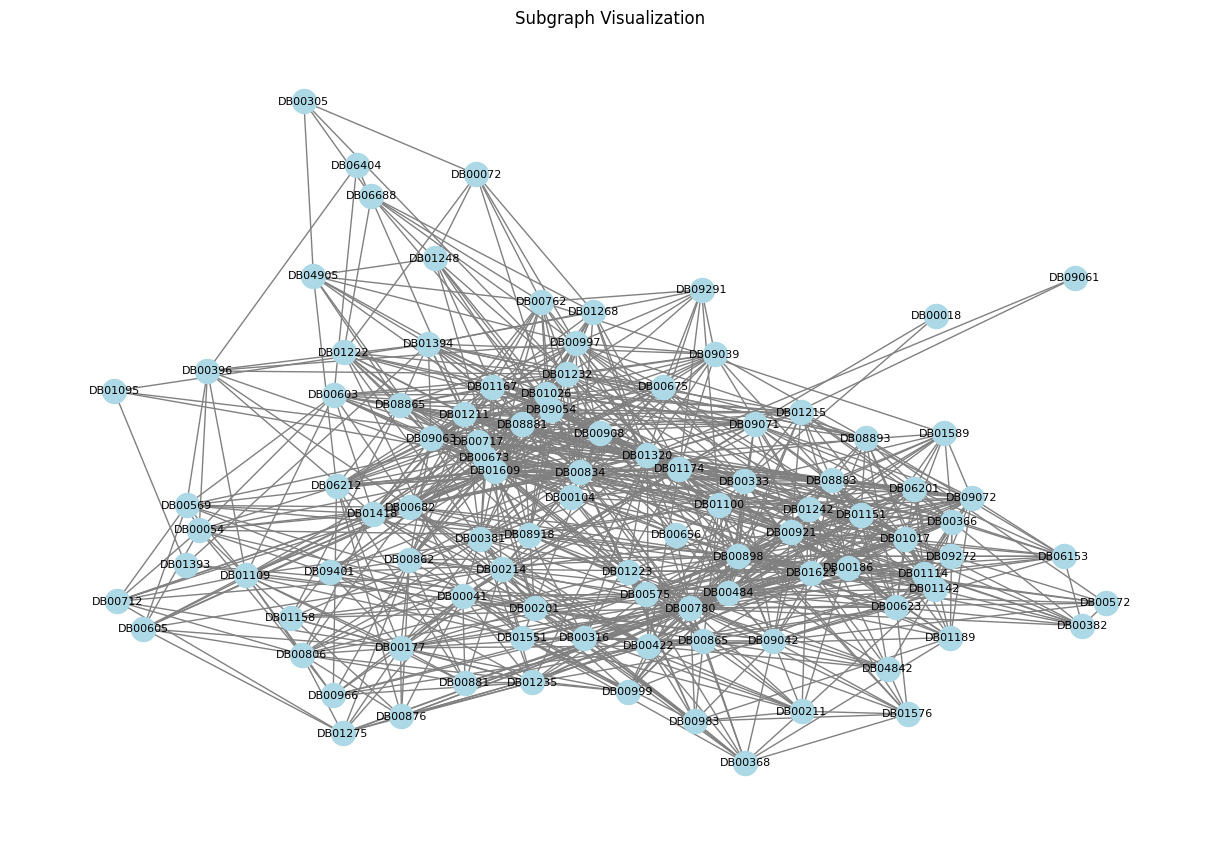

In [11]:
# Create a subgraph with the first 100 nodes for visualization
subgraph_nodes = list(G.nodes())[:100]
subgraph = G.subgraph(subgraph_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for positioning nodes
nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray', font_size=8)
plt.title('Subgraph Visualization')
plt.show()

# Graph centralities analysis

In [12]:
# Function to print top 10 nodes for a centrality measure
def print_top_10(centrality, name):
    sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 10 nodes for {name}:")
    for node, value in sorted_centrality[:10]:
        print(f"Node: {node}, {name}: {value:.4f}")
    print()

# Function to plot centrality distribution
def plot_centrality_distribution(centrality, name):
    plt.figure(figsize=(10, 6))
    plt.hist(centrality.values(), bins=50, color='blue', alpha=0.7)
    plt.title(f'{name} Distribution')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## Degree Centrality

Top 10 nodes for Degree Centrality:
Node: DB00252, Degree Centrality: 0.2928
Node: DB00834, Degree Centrality: 0.2505
Node: DB00715, Degree Centrality: 0.2439
Node: DB00752, Degree Centrality: 0.2373
Node: DB00780, Degree Centrality: 0.2267
Node: DB00682, Degree Centrality: 0.2227
Node: DB01609, Degree Centrality: 0.2181
Node: DB00220, Degree Centrality: 0.2135
Node: DB00470, Degree Centrality: 0.2062
Node: DB00363, Degree Centrality: 0.2062



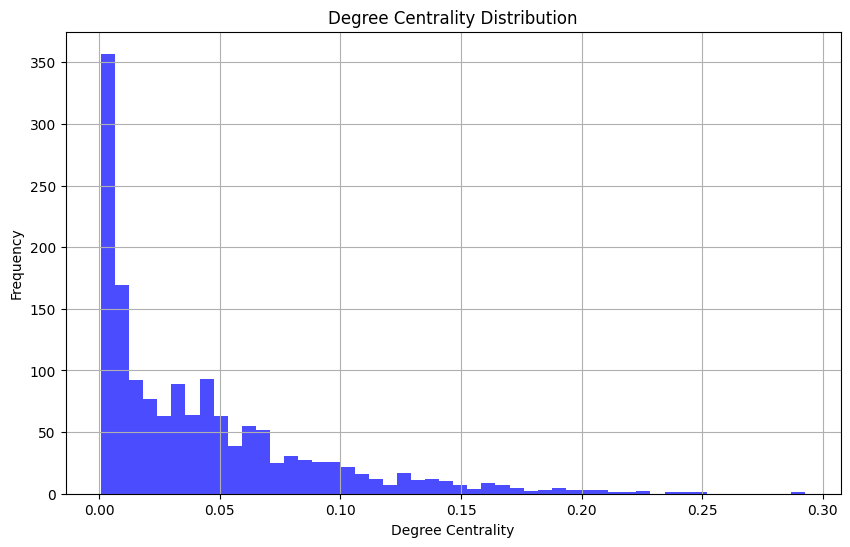

In [13]:
# 1. Degree Centrality
degree_centrality = nx.degree_centrality(G)
print_top_10(degree_centrality, "Degree Centrality")
plot_centrality_distribution(degree_centrality, "Degree Centrality")

## Eigenvector centrality

Top 10 nodes for Eigenvector Centrality:
Node: DB00252, Eigenvector Centrality: 0.1086
Node: DB00834, Eigenvector Centrality: 0.1044
Node: DB00956, Eigenvector Centrality: 0.0919
Node: DB01238, Eigenvector Centrality: 0.0916
Node: DB00715, Eigenvector Centrality: 0.0880
Node: DB00564, Eigenvector Centrality: 0.0878
Node: DB00503, Eigenvector Centrality: 0.0876
Node: DB00220, Eigenvector Centrality: 0.0873
Node: DB08912, Eigenvector Centrality: 0.0826
Node: DB01609, Eigenvector Centrality: 0.0826



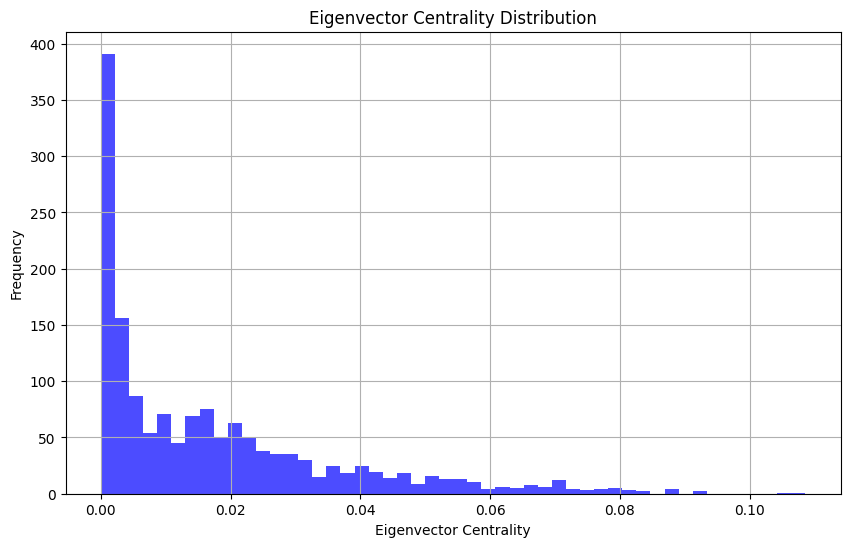

In [14]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
print_top_10(eigenvector_centrality, "Eigenvector Centrality")
plot_centrality_distribution(eigenvector_centrality, "Eigenvector Centrality")

## Katz Centrality

In [22]:
is_connected = nx.is_connected(G)

Top 10 nodes for Katz Centrality:
Node: DB00834, Katz Centrality: 0.1198
Node: DB00252, Katz Centrality: 0.1174
Node: DB00956, Katz Centrality: 0.1072
Node: DB01238, Katz Centrality: 0.1047
Node: DB00220, Katz Centrality: 0.1025
Node: DB00503, Katz Centrality: 0.1015
Node: DB00564, Katz Centrality: 0.1011
Node: DB09118, Katz Centrality: 0.0994
Node: DB08912, Katz Centrality: 0.0971
Node: DB09054, Katz Centrality: 0.0960



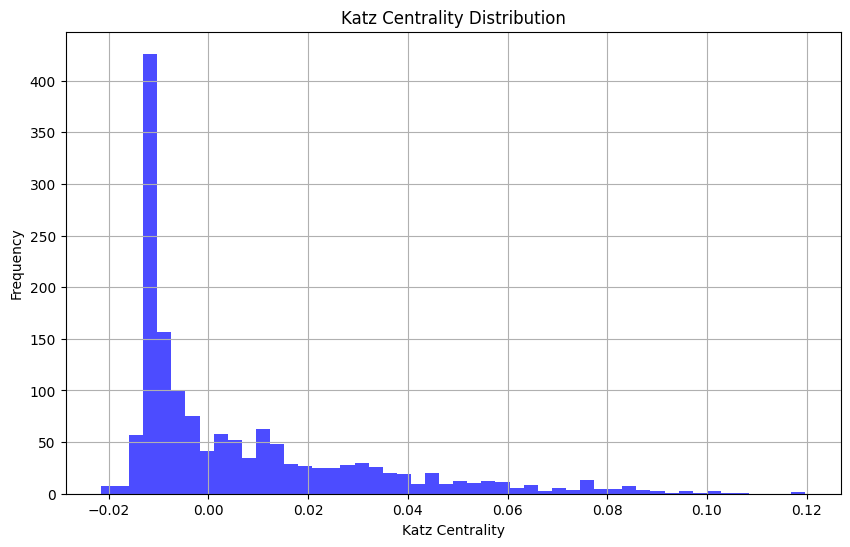

In [26]:
katz_centrality = nx.katz_centrality_numpy(G, alpha=0.01, beta=1.0)
print_top_10(katz_centrality, "Katz Centrality")
plot_centrality_distribution(katz_centrality, "Katz Centrality")

## PageRank Centrality

Top 10 nodes for PageRank Centrality:
Node: DB00682, PageRank Centrality: 0.0045
Node: DB00252, PageRank Centrality: 0.0041
Node: DB01418, PageRank Centrality: 0.0039
Node: DB00834, PageRank Centrality: 0.0033
Node: DB01609, PageRank Centrality: 0.0032
Node: DB00363, PageRank Centrality: 0.0032
Node: DB00715, PageRank Centrality: 0.0031
Node: DB00752, PageRank Centrality: 0.0031
Node: DB00864, PageRank Centrality: 0.0030
Node: DB00266, PageRank Centrality: 0.0029



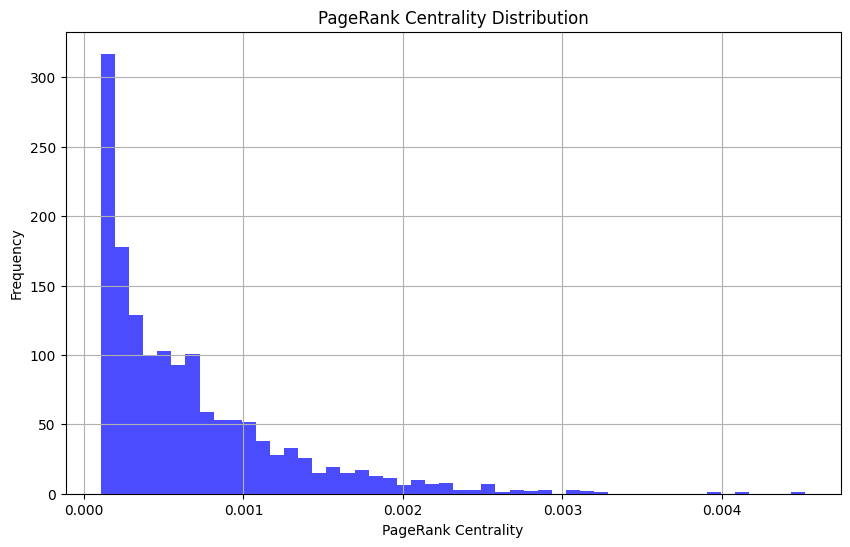

In [17]:
pagerank_centrality = nx.pagerank(G, alpha=0.85)
print_top_10(pagerank_centrality, "PageRank Centrality")
plot_centrality_distribution(pagerank_centrality, "PageRank Centrality")

## Clustering Coefficient Centrality

Top 10 nodes for Clustering Coefficient:
Node: DB01438, Clustering Coefficient: 1.0000
Node: DB01159, Clustering Coefficient: 1.0000
Node: DB00583, Clustering Coefficient: 1.0000
Node: DB00743, Clustering Coefficient: 1.0000
Node: DB04711, Clustering Coefficient: 1.0000
Node: DB00210, Clustering Coefficient: 1.0000
Node: DB09135, Clustering Coefficient: 1.0000
Node: DB06659, Clustering Coefficient: 1.0000
Node: DB01086, Clustering Coefficient: 1.0000
Node: DB01127, Clustering Coefficient: 1.0000



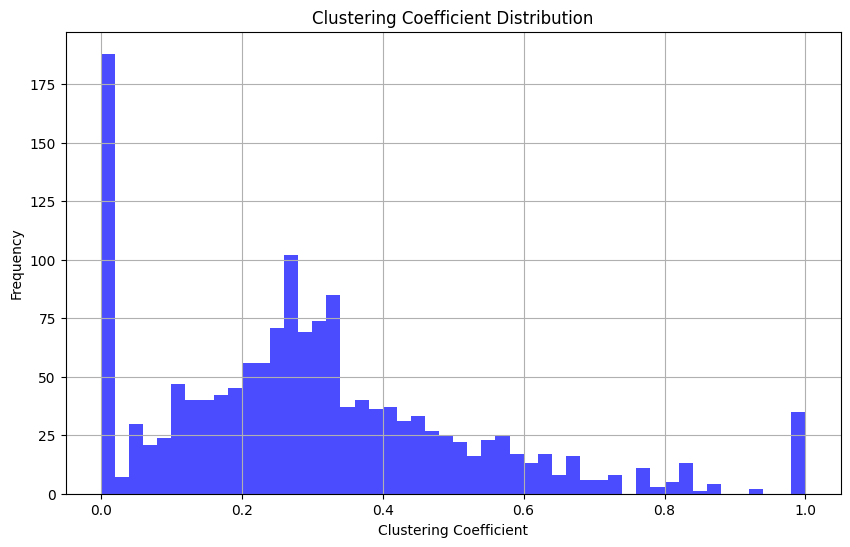

In [18]:
clustering_coefficient = nx.clustering(G)
print_top_10(clustering_coefficient, "Clustering Coefficient")
plot_centrality_distribution(clustering_coefficient, "Clustering Coefficient")

## Closeness Centrality

Top 10 nodes for Closeness Centrality:
Node: DB00252, Closeness Centrality: 0.5545
Node: DB00834, Closeness Centrality: 0.5402
Node: DB01609, Closeness Centrality: 0.5260
Node: DB00794, Closeness Centrality: 0.5249
Node: DB00220, Closeness Centrality: 0.5237
Node: DB00715, Closeness Centrality: 0.5228
Node: DB00682, Closeness Centrality: 0.5222
Node: DB01320, Closeness Centrality: 0.5209
Node: DB00503, Closeness Centrality: 0.5200
Node: DB00564, Closeness Centrality: 0.5193



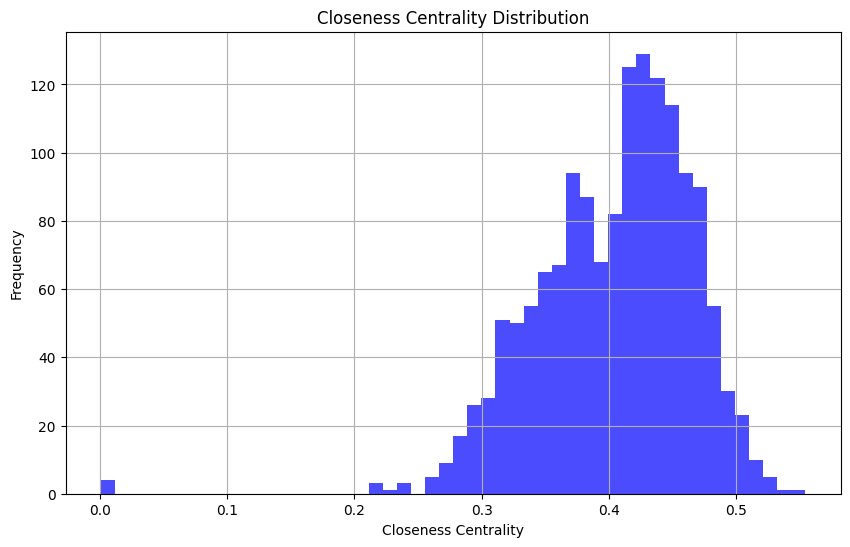

In [19]:
closeness_centrality = nx.closeness_centrality(G)
print_top_10(closeness_centrality, "Closeness Centrality")
plot_centrality_distribution(closeness_centrality, "Closeness Centrality")


## Betweenness Centrality

Top 10 nodes for Betweenness Centrality:
Node: DB00682, Betweenness Centrality: 0.0420
Node: DB01418, Betweenness Centrality: 0.0290
Node: DB00252, Betweenness Centrality: 0.0284
Node: DB00363, Betweenness Centrality: 0.0276
Node: DB00864, Betweenness Centrality: 0.0206
Node: DB01609, Betweenness Centrality: 0.0199
Node: DB00266, Betweenness Centrality: 0.0186
Node: DB00091, Betweenness Centrality: 0.0178
Node: DB00715, Betweenness Centrality: 0.0168
Node: DB09268, Betweenness Centrality: 0.0165



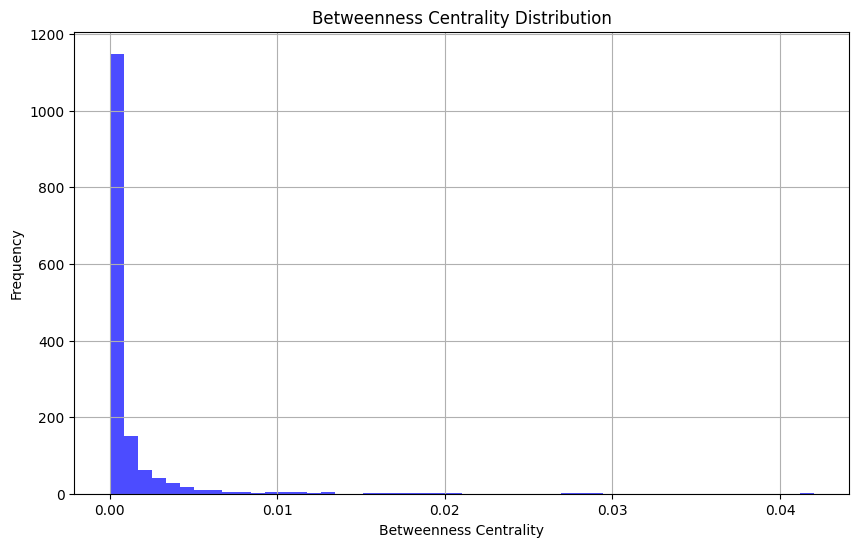

In [20]:
betweenness_centrality = nx.betweenness_centrality(G)
print_top_10(betweenness_centrality, "Betweenness Centrality")
plot_centrality_distribution(betweenness_centrality, "Betweenness Centrality")

## Conclusions

In [29]:
# Borda Count to determine the most central node
def borda_count(centralities):
    borda_scores = {}
    for centrality in centralities:
        sorted_nodes = sorted(centrality.keys(), key=lambda x: centrality[x], reverse=True)
        for rank, node in enumerate(sorted_nodes):
            if node not in borda_scores:
                borda_scores[node] = 0
            borda_scores[node] += len(sorted_nodes) - rank
    return borda_scores

# List of all centrality measures
centralities = [
    degree_centrality,
    eigenvector_centrality,
    katz_centrality,
    pagerank_centrality,
    # clustering_coefficient,
    closeness_centrality,
    betweenness_centrality
]

# Compute Borda count
borda_scores = borda_count(centralities)
sorted_borda = sorted(borda_scores.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes based on Borda count
print("Top 10 nodes based on Borda count:")
for node, score in sorted_borda[:10]:
    print(f"Node: {node}, Borda Score: {score}")


Top 10 nodes based on Borda count:
Node: DB00252, Borda Score: 9080
Node: DB00834, Borda Score: 9068
Node: DB01609, Borda Score: 9038
Node: DB00715, Borda Score: 9022
Node: DB00220, Borda Score: 9004
Node: DB00503, Borda Score: 9001
Node: DB01320, Borda Score: 9000
Node: DB01238, Borda Score: 8999
Node: DB00564, Borda Score: 8991
Node: DB00956, Borda Score: 8986


# Community detection Analysis